# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [3]:
LEARNING_RATE = 1e-3
EPOCHS = 250
PATIENCE = 25
BATCH_SIZE = 64

In [4]:
#data = np.load("/kaggle/input/mars-github/mars_cleaned_and_augmented.npz")
data = np.load("mars_for_students_cleaned.npz")

training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

print(X_train[0])

X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train[..., np.newaxis]


training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)
[[81. 86. 86. ... 82. 83. 83.]
 [84. 85. 81. ... 77. 77. 80.]
 [85. 85. 84. ... 61. 65. 71.]
 ...
 [69. 73. 76. ... 66. 65. 63.]
 [74. 77. 78. ... 64. 63. 63.]
 [71. 74. 76. ... 65. 66. 70.]]


In [5]:
# separate in train val test
from sklearn.model_selection import train_test_split
SEED=42
SPLITS_SIZE=300
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [6]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
      ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [8]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")


Creating datasets...


<ipython-input-7-b58cb7234dec>:52: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-7-b58cb7234dec>:52: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-7-b58cb7234dec>:52: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)


WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!


## 🛠️ Train and Save the Model

In [9]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [11]:
NUM_CLASSES = 5
SEED = 42

def MV2Block(input_channels, output_channels, stride=1, block_id=0):
    """
    Implémentation d'un bloc MobileNetV2 (MV2).

    Arguments :
    - input_channels : Nombre de canaux en entrée.
    - output_channels : Nombre de canaux en sortie.
    - stride : Stride pour la convolution depthwise (1 ou 2).
    - block_id : Identifiant unique pour le bloc.

    Retourne :
    - Un bloc MV2 en tant que modèle Keras fonctionnel.
    """
    inputs = tfkl.Input(shape=(None, None, input_channels))

    # Convolution 1x1 (Pointwise), suivie de BN et SiLU
    x = tfkl.Conv2D(input_channels, kernel_size=1, strides=1, padding='same', use_bias=False)(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('swish')(x)  # SiLU activation

    # Convolution Depthwise 3x3
    x = tfkl.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('swish')(x)  # SiLU activation

    # Convolution 1x1 (Pointwise) pour réduction des dimensions
    x = tfkl.Conv2D(output_channels, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)

    # Si stride == 1, on applique un shortcut connection
    if stride == 1 and input_channels == output_channels:
        x = tfkl.Add()([inputs, x])

    return tf.keras.Model(inputs, x, name=f"MV2Block_s{stride}_b{block_id}")

def transformer_block(inputs, num_heads, projection_dim, transformer_layers):
    """
    Implements the transformer block with multi-head self-attention and feedforward layers.
    """
    x = inputs
    for _ in range(transformer_layers):
        # Layer Normalization
        x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
        # Multi-head self-attention
        attention_output = tfkl.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        # Skip connection
        x2 = tfkl.Add()([x, attention_output])
        # Feedforward
        x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)
        ff_output = tfk.Sequential([
            tfkl.Dense(4 * projection_dim, activation='gelu'),
            tfkl.Dense(projection_dim),
        ])(x3)
        # Skip connection
        x = tfkl.Add()([x2, ff_output])
    return x

def mvvit_block(input_tensor, num_heads, projection_dim, transformer_layers, block_id=0):
    """
    Implements the MViT block as shown in the diagram.
    """
    # Convolutional path
    x_conv = tfkl.Conv2D(filters=projection_dim, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x_conv = tfkl.Conv2D(filters=projection_dim, kernel_size=1, padding='same', activation='relu')(x_conv)

    # Flatten for transformer input (reshape to [N, P, d])
    batch_size, height, width, channels = tf.keras.backend.int_shape(x_conv)
    x_flatten = tfkl.Reshape((height * width, projection_dim))(x_conv)
    # Transformer for global representation
    x_transformer = transformer_block(x_flatten, num_heads, projection_dim, transformer_layers)

    # Reshape back to spatial dimensions
    x_reshaped = tfkl.Reshape((height, width, projection_dim))(x_transformer)

    # Convolution to merge outputs
    x_merge = tfkl.Conv2D(filters=input_tensor.shape[-1], kernel_size=1, padding='same')(x_reshaped)

    # Skip connection
    x_skip = tfkl.Add()([input_tensor, x_merge])

    # Final convolution to project back to HxWxC
    output = tfkl.Conv2D(filters=input_tensor.shape[-1], kernel_size=3, padding='same')(x_skip)

    return output

def LightweightEncoder(input_shape, mv2_channels, mvit_params):
    """
    Implements the Lightweight Encoder from the provided diagram.

    Arguments:
    - input_shape: Shape of the input tensor (H, W, C).
    - mv2_channels: List of output channels for each MV2Block stage.
    - mvit_params: Dictionary containing the parameters for the MViT blocks (e.g., heads, dim, layers).

    Returns:
    - A Keras Model implementing the Lightweight Encoder.
    - Outputs of each stage.
    """
    inputs = tfk.Input(shape=input_shape)

    # Stage 1
    x = tfkl.Conv2D(filters=mv2_channels[0], kernel_size=3, strides=2, padding='same', activation='relu')(inputs)  # Downsample by 2
    x = MV2Block(input_channels=mv2_channels[0], output_channels=mv2_channels[0], block_id=1)(x)
    F1 = x  # Output of Stage 1

    # Stage 2
    x = MV2Block(input_channels=mv2_channels[0], output_channels=mv2_channels[1], stride=2, block_id=21)(x)  # Downsample by 2
    x = MV2Block(input_channels=mv2_channels[1], output_channels=mv2_channels[1], block_id=22)(x)
    F2 = x  # Output of Stage 2

    # Stage 3
    x = MV2Block(input_channels=mv2_channels[1], output_channels=mv2_channels[2], stride=2, block_id=3)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=3)
    F3 = x  # Output of Stage 3

    # Stage 4
    x = MV2Block(input_channels=mv2_channels[2], output_channels=mv2_channels[3], stride=2, block_id=4)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=4)
    x = tfkl.Conv2D(filters=mv2_channels[3], kernel_size=1, strides=1, padding='same')(x)
    F4 = x  # Output of Stage 4

    # Stage 5
    """
    x = MV2Block(input_channels=mv2_channels[3], output_channels=mv2_channels[4], stride=2, block_id=5)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=5)
    x = tfkl.Conv2D(filters=mv2_channels[4], kernel_size=1, strides=1, padding='same')(x)
    F5 = x  # Output of Stage 5
    """
    # Model
    encoder_model = tfk.Model(inputs, [F1, F2, F3, F4], name="LightweightEncoder")
    return encoder_model

def CFF(input_tensor_i, input_tensor_i_plus_1, filters):
    """
    Cross-Feature Fusion (CFF) module.

    Arguments:
    - input_tensor_i: Input tensor from encoder stage i.
    - input_tensor_i_plus_1: Input tensor from encoder stage i+1.
    - filters: Number of filters for the 1x1 convolutions.

    Returns:
    - Two output tensors:
        1. The upsampled tensor from stage i+1.
        2. The fused tensor after concatenation and 1x1 convolution.
    """
    # Upsample the input tensor from stage i+1 by a factor of 2
    upsampled_i_plus_1 = tfkl.UpSampling2D(size=(2, 2))(input_tensor_i_plus_1)

    # Apply 1x1 convolution to the input tensor from stage i
    conv_i = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor_i)

    # Concatenate the upsampled tensor from stage i+1 and the convolved tensor from stage i
    concatenated = tfkl.Concatenate()([upsampled_i_plus_1, conv_i])

    # Apply another 1x1 convolution to the concatenated tensor
    fused = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(concatenated)

    return upsampled_i_plus_1, fused


def CFA(feature_maps, filters):
    """
    Compact Feature Aggregation (CFA) module.

    Arguments:
    - feature_maps: List of feature maps from CFF modules.
    - filters: Number of filters for the 1x1 convolution.

    Returns:
    - Fused feature map.
    """
    # Reshape high-level feature maps to the same size as the lowest resolution feature map
    reshaped_feature_maps = []
    for feature_map in feature_maps[:2]:
        reshaped_feature_map = tfkl.UpSampling2D(size=(2 ** (2 - feature_maps.index(feature_map))))(feature_map)
        reshaped_feature_maps.append(reshaped_feature_map)

    for feature_map in feature_maps[2:]:
        reshaped_feature_maps.append(feature_map)
    # Concatenate all feature maps
    concatenated = tfkl.Concatenate()(reshaped_feature_maps)

    # Apply 1x1 convolution for feature fusion
    fused = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(concatenated)

    # Final 2* upsample to the original input size
    output = tfkl.UpSampling2D(size=(2, 2))(fused)

    return output


def ELAD(encoder_model, num_classes, mv2_channels):
    """
    Efficient Lightweight Aggregation Decoder (ELAD).

    Arguments:
    - encoder_model: The encoder model.
    - num_classes: Number of classes for the segmentation task.
    - mv2_channels: List of output channels for each MV2Block stage.

    Returns:
    - A Keras Model implementing the ELAD.
    """
    encoder_outputs = encoder_model.output
    F1, F2, F3, F4 = encoder_outputs
    #print(F1.shape, F2.shape, F3.shape, F4.shape, F5.shape)

    # conv1x1 to reduce the number of channels
    F4 = tfkl.Conv2D(filters=mv2_channels[4], kernel_size=1, padding='same', activation='relu')(F4)

    # Apply CFF modules
    # C5, fused_F4_F3 = CFF(F4, F5, mv2_channels[3])
    C4, fused_F3_F2 = CFF(F3, F4, mv2_channels[2])
    C3, fused_F2_F1 = CFF(F2, fused_F3_F2, mv2_channels[1])
    C2, fused_F1 = CFF(F1, fused_F2_F1, mv2_channels[0])

    # Collect all feature maps for CFA
    feature_maps = [ C4, C3, C2, fused_F1]

    # Apply CFA module
    fused_features = CFA(feature_maps, mv2_channels[0])

    # Final convolution to project to the number of classes
    output = tfkl.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax')(fused_features)

    # Model
    return tfk.Model(encoder_model.input, output, name="ELAD")

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def attention_gate(x, g, filters, kernel_size=3, activation='relu', name=''):
    """
    Mécanisme de porte d'attention pour fusionner les caractéristiques d'entrée.

    :param x: Caractéristiques d'entrée (généralement provenant de la partie encoding).
    :param g: Caractéristiques d'entrée (généralement provenant de la partie decoding).
    :param filters: Nombre de filtres pour les convolutions.
    :param kernel_size: Taille du noyau de la convolution.
    :param activation: Fonction d'activation.
    :param name: Nom de la couche.
    :return: Sortie du mécanisme d'attention.
    """
    # Convolution sur les caractéristiques d'entrée (x) et sur les caractéristiques de "gating" (g)
    f = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_f')(x)
    g = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_g')(g)

    # Fusion des deux convolutions (ajout ou concaténation)
    h = tfkl.Add()([f, g])  # Ou utilisez une concaténation
    h = tfkl.Activation(activation)(h)

    # Applique une convolution pour affiner l'attention
    attention = tfkl.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name=name + '_attention')(h)

    # Multiplie les caractéristiques avec la carte d'attention
    out = tfkl.Multiply()([x, attention])
    return out


def attention_gate(x, g, filters, kernel_size=3, activation='relu', name=''):
    """
    Mécanisme de porte d'attention pour fusionner les caractéristiques d'entrée.

    :param x: Caractéristiques d'entrée (généralement provenant de la partie encoding).
    :param g: Caractéristiques d'entrée (généralement provenant de la partie decoding).
    :param filters: Nombre de filtres pour les convolutions.
    :param kernel_size: Taille du noyau de la convolution.
    :param activation: Fonction d'activation.
    :param name: Nom de la couche.
    :return: Sortie du mécanisme d'attention.
    """
    # Convolution sur les caractéristiques d'entrée (x) et sur les caractéristiques de "gating" (g)
    f = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_f')(x)
    g = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_g')(g)

    # Fusion des deux convolutions (ajout ou concaténation)
    h = tfkl.Add()([f, g])  # Ou utilisez une concaténation
    h = tfkl.Activation(activation)(h)

    # Applique une convolution pour affiner l'attention
    attention = tfkl.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name=name + '_attention')(h)

    # Multiplie les caractéristiques avec la carte d'attention
    out = tfkl.Multiply()([x, attention])
    return out


def Unet_decoder(encoder_model, num_classes, mv2_channels):
    """
    U-Net decoder for semantic segmentation.

    Arguments:
    - encoder_model: The encoder model.
    - num_classes: Number of classes for the segmentation task.
    - mv2_channels: List of output channels for each MV2Block stage.

    Returns:
    - A Keras Model implementing the U-Net decoder.
    """
    encoder_outputs = encoder_model.output
    F1, F2, F3, F4 = encoder_outputs

    bottleneck = unet_block(F4, mv2_channels[3], name='bottleneck')

    # Upsampling path
    upsampled_1 = tfkl.UpSampling2D(size=(2, 2))(bottleneck)
    upsampled_1 = attention_gate(F3, upsampled_1, mv2_channels[2], name='attention_gate1')
    upsampled_1 = unet_block(upsampled_1, mv2_channels[2], name='up1')

    upsampled_2 = tfkl.UpSampling2D(size=(2, 2))(upsampled_1)
    upsampled_2 = attention_gate(F2, upsampled_2, mv2_channels[1], name='attention_gate2')
    upsampled_2 = unet_block(upsampled_2, mv2_channels[1], name='up2')

    upsampled_3 = tfkl.UpSampling2D(size=(2, 2))(upsampled_2)
    upsampled_3 = attention_gate(F1, upsampled_3, mv2_channels[0], name='attention_gate3')
    upsampled_3 = unet_block(upsampled_3, mv2_channels[0], name='up3')

    upsample_4 = tfkl.UpSampling2D(size=(2, 2))(upsampled_3)
    upsample_4 = unet_block(upsample_4, mv2_channels[0], name='up4')

    # Final convolution to project to the number of classes
    output = tfkl.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax')(upsample_4)
    # Model
    return tfk.Model(encoder_model.input, output, name="Unet_decoder")

def SegMarsViT(input_shape, mv2_channels, mvit_params, num_classes):
    """
    Creates the SegMarsViT model.

    Arguments:
    - input_shape: Shape of the input tensor (H, W, C).
    - mv2_channels: List of output channels for each MV2Block stage.
    - mvit_params: Dictionary containing the parameters for the MViT blocks (e.g., heads, dim, layers).
    - num_classes: Number of classes for the segmentation task.

    Returns:
    - A Keras Model implementing the SegMarsViT.
    """
    # Create the Lightweight Encoder
    encoder_model = LightweightEncoder(input_shape, mv2_channels, mvit_params)

    # Create the ELAD Decoder
    model = Unet_decoder(encoder_model, num_classes, mv2_channels)

    return model

# Parameters for the encoder
input_shape = (64, 128, 1)  # Example input shape (H, W, C)
mvit_params = {
    'num_heads': 4,
    'projection_dim': 128,
    'transformer_layers': 3
}

# Define the mv2_channels list for different network sizes
mv2_channels_s = [16, 32, 64, 128, 160]
mv2_channels_xs = [16, 24, 48, 80, 96]
mv2_channels_xxs = [16, 16, 24, 48, 64]

# Create the SegMarsViT models for different network sizes
# model = SegMarsViT(input_shape, mv2_channels_s, mvit_params, NUM_CLASSES)


#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)




def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2D(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)

    if activation is None:
        return x

    x = tfkl.Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2DTranspose(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha=1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    out = tfkl.concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = tfkl.BatchNormalization(axis=3)(out)

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- number of filters
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    for i in range(length - 1):
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = tfkl.add([shortcut, out])
        out = tfkl.Activation('relu')(out)
        out = tfkl.BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = tfk.Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = tfkl.concatenate([tfkl.Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = tfkl.concatenate([tfkl.Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = tfkl.concatenate([tfkl.Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = tfkl.concatenate([tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 5, 1, 1, activation='softmax')

    model = tfk.Model(inputs=[inputs], outputs=[conv10])

    return model


model = MultiResUnet(64,128, 1)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def weighted_iou_loss(y_true, y_pred, epsilon=1e-6):
    """
    Computes the weighted IoU loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.
    - epsilon: Small constant to avoid division by zero.

    Returns:
    - Weighted IoU loss.
    """

    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # 5 classes pour la segmentation

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return 1 - iou

def weighted_bce_loss(y_true, y_pred):
    """
    Computes the weighted BCE loss.

    Arguments:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities.

    Returns:
    - Weighted BCE loss.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    return bce(y_true, y_pred)

def custom_loss(y_true, y_pred):
    """
    Computes the combined weighted IoU and BCE loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.

    Returns:
    - Combined weighted IoU and BCE loss.
    """
    iou_loss = weighted_iou_loss(y_true, y_pred)
    bce_loss = weighted_bce_loss(y_true, y_pred)
    return iou_loss + bce_loss



In [13]:
from keras import backend as K


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (
    1 + tf.cos(
        tf.constant(np.pi, dtype=tf.float32) *
        (tf.cast(global_step, tf.float32) - tf.cast(warmup_steps, tf.float32) - tf.cast(hold, tf.float32)) /
        float(total_steps - warmup_steps - hold)
    )
    )


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )

    def get_config(self):
        return {
            "start_lr": self.start_lr,
            "target_lr": self.target_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "hold": self.hold
        }


In [17]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# If batched
total_steps = len(train_dataset)*EPOCHS
# 5% of the steps
warmup_steps = int(0.10*total_steps)

lr_schedule = WarmUpCosineDecay(start_lr=0.0, target_lr=LEARNING_RATE, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy,
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

Epoch 1/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6669 - loss: 0.8748 - mean_iou: 0.3729   

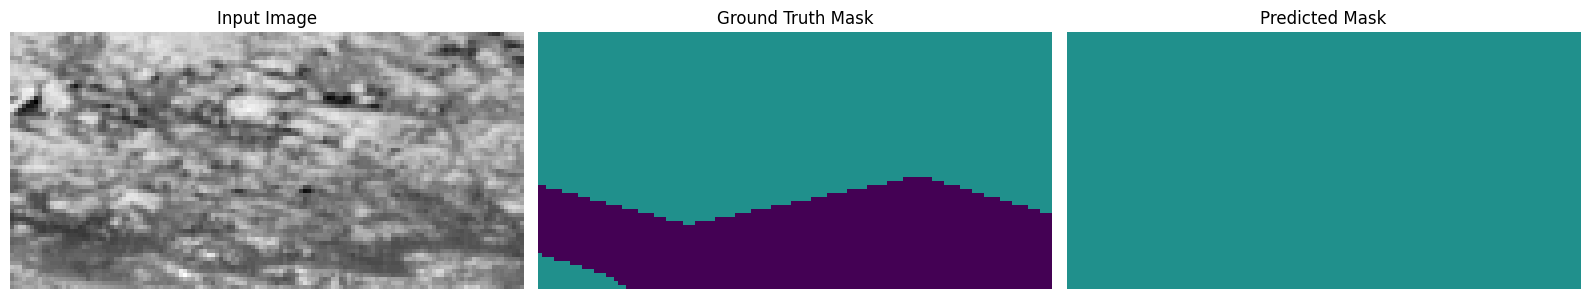

30/30 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6676 - loss: 0.8735 - mean_iou: 0.3735 - val_accuracy: 0.6361 - val_loss: 1.2270 - val_mean_iou: 0.3711
Epoch 2/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 525ms/step - accuracy: 0.6768 - loss: 0.8659 - mean_iou: 0.3813 - val_accuracy: 0.6605 - val_loss: 0.9936 - val_mean_iou: 0.3968
Epoch 3/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.6744 - loss: 0.8484 - mean_iou: 0.3764 - val_accuracy: 0.6845 - val_loss: 0.8553 - val_mean_iou: 0.4200
Epoch 4/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.6771 - loss: 0.8525 - mean_iou: 0.3824 - val_accuracy: 0.7018 - val_loss: 0.7795 - val_mean_iou: 0.4343
Epoch 5/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.6815 - loss: 0.8420 - mean_iou: 0.3824 - val_accuracy: 0.7145 - val_loss: 0.7428 - val_mean_iou: 0.4423
Epoch 6/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6908 - loss: 0.8264 - mean_iou: 0.4005

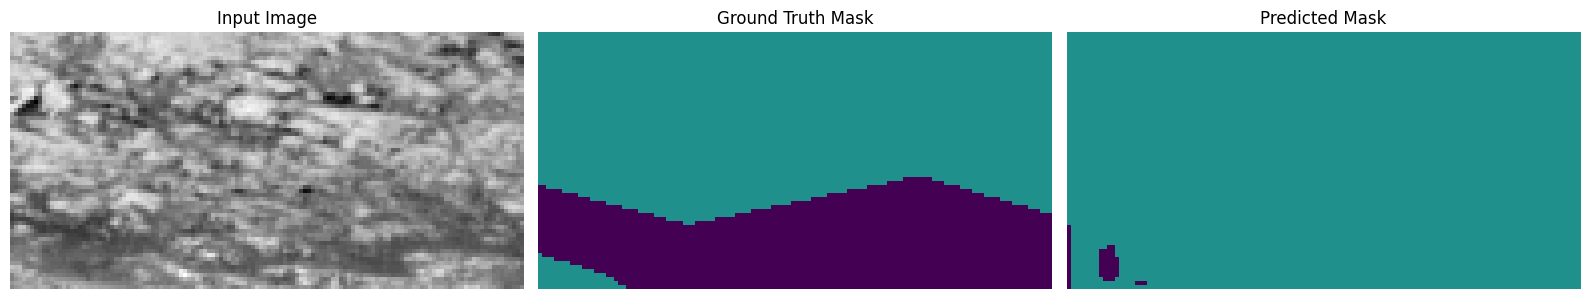

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - accuracy: 0.6913 - loss: 0.8253 - mean_iou: 0.4009 - val_accuracy: 0.7232 - val_loss: 0.7329 - val_mean_iou: 0.4463
Epoch 7/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.6966 - loss: 0.8212 - mean_iou: 0.3984 - val_accuracy: 0.7278 - val_loss: 0.7359 - val_mean_iou: 0.4459
Epoch 8/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.6849 - loss: 0.8345 - mean_iou: 0.3929 - val_accuracy: 0.7274 - val_loss: 0.7409 - val_mean_iou: 0.4404
Epoch 9/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step - accuracy: 0.6906 - loss: 0.8242 - mean_iou: 0.3933 - val_accuracy: 0.7272 - val_loss: 0.7445 - val_mean_iou: 0.4340
Epoch 10/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.7023 - loss: 0.8046 - mean_iou: 0.4060 - val_accuracy: 0.7232 - val_loss: 0.7512 - val_mean_iou: 0.4259
Epoch 11/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7039 - loss: 0.8048 - mean_iou: 0.4106

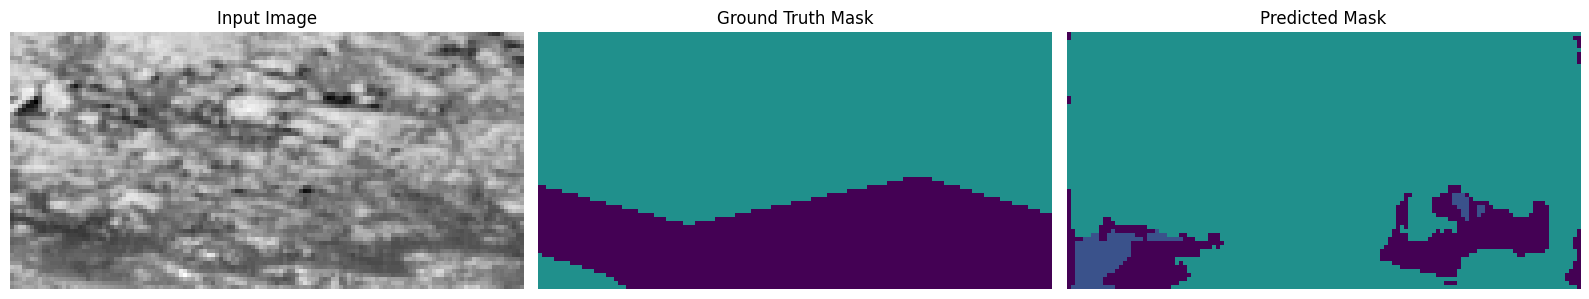

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 538ms/step - accuracy: 0.7042 - loss: 0.8040 - mean_iou: 0.4109 - val_accuracy: 0.7316 - val_loss: 0.7437 - val_mean_iou: 0.4345
Epoch 12/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 533ms/step - accuracy: 0.7007 - loss: 0.8025 - mean_iou: 0.4091 - val_accuracy: 0.7343 - val_loss: 0.7394 - val_mean_iou: 0.4359
Epoch 13/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 514ms/step - accuracy: 0.7054 - loss: 0.8030 - mean_iou: 0.4121 - val_accuracy: 0.7374 - val_loss: 0.7385 - val_mean_iou: 0.4372
Epoch 14/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.7064 - loss: 0.7974 - mean_iou: 0.4108 - val_accuracy: 0.7352 - val_loss: 0.7416 - val_mean_iou: 0.4323
Epoch 15/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.7098 - loss: 0.7841 - mean_iou: 0.4126 - val_accuracy: 0.7534 - val_loss: 0.7180 - val_mean_iou: 0.4519
Epoch 16/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7190 - loss: 0.7774 - mean_iou: 0.4245

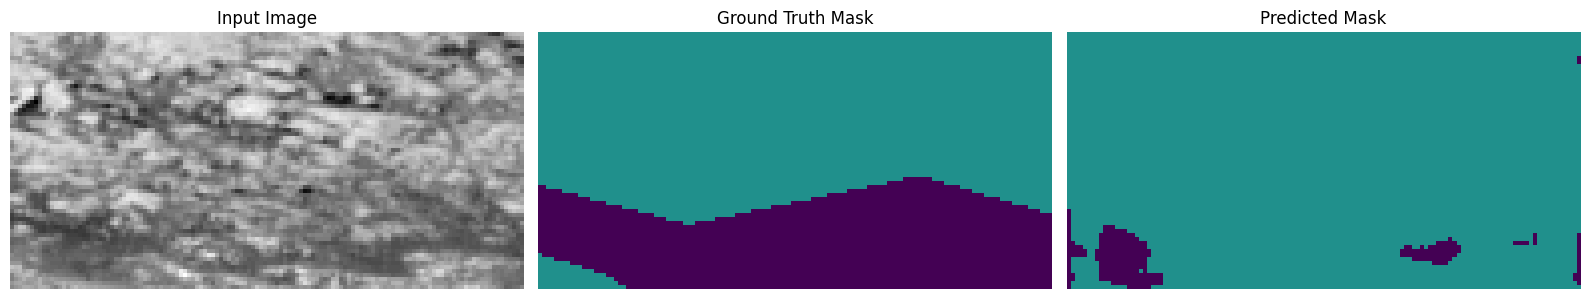

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - accuracy: 0.7191 - loss: 0.7769 - mean_iou: 0.4246 - val_accuracy: 0.7563 - val_loss: 0.7148 - val_mean_iou: 0.4553
Epoch 17/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.7106 - loss: 0.7840 - mean_iou: 0.4158 - val_accuracy: 0.7531 - val_loss: 0.7169 - val_mean_iou: 0.4514
Epoch 18/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 530ms/step - accuracy: 0.7048 - loss: 0.7843 - mean_iou: 0.4082 - val_accuracy: 0.7535 - val_loss: 0.7175 - val_mean_iou: 0.4514
Epoch 19/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step - accuracy: 0.7114 - loss: 0.7821 - mean_iou: 0.4207 - val_accuracy: 0.7517 - val_loss: 0.7159 - val_mean_iou: 0.4503
Epoch 20/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.7144 - loss: 0.7742 - mean_iou: 0.4180 - val_accuracy: 0.7646 - val_loss: 0.7010 - val_mean_iou: 0.4631
Epoch 21/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7136 - loss: 0.7758 - mean_iou: 0.4161

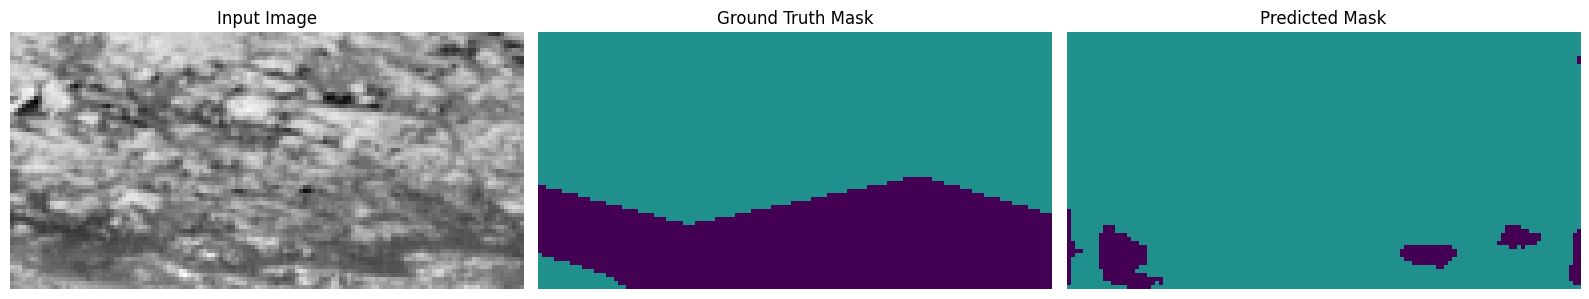

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 533ms/step - accuracy: 0.7140 - loss: 0.7751 - mean_iou: 0.4164 - val_accuracy: 0.7636 - val_loss: 0.6938 - val_mean_iou: 0.4609
Epoch 22/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.7111 - loss: 0.7763 - mean_iou: 0.4153 - val_accuracy: 0.7661 - val_loss: 0.6927 - val_mean_iou: 0.4639
Epoch 23/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.7227 - loss: 0.7614 - mean_iou: 0.4270 - val_accuracy: 0.7654 - val_loss: 0.6941 - val_mean_iou: 0.4630
Epoch 24/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.7188 - loss: 0.7675 - mean_iou: 0.4250 - val_accuracy: 0.7667 - val_loss: 0.6879 - val_mean_iou: 0.4637
Epoch 25/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 525ms/step - accuracy: 0.7164 - loss: 0.7678 - mean_iou: 0.4166 - val_accuracy: 0.7693 - val_loss: 0.6867 - val_mean_iou: 0.4674
Epoch 26/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7225 - loss: 0.7583 - mean_iou: 0.4236

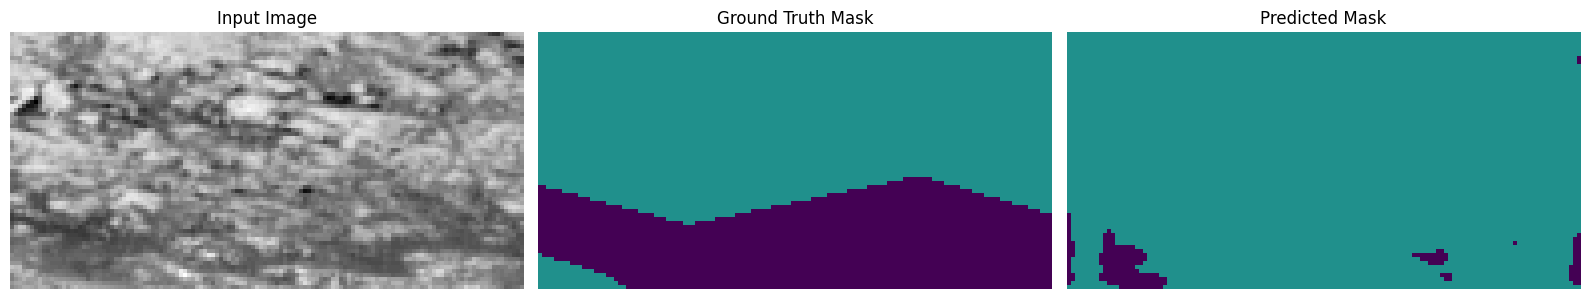

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.7228 - loss: 0.7576 - mean_iou: 0.4240 - val_accuracy: 0.7711 - val_loss: 0.6793 - val_mean_iou: 0.4737
Epoch 27/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7279 - loss: 0.7487 - mean_iou: 0.4313 - val_accuracy: 0.7751 - val_loss: 0.6760 - val_mean_iou: 0.4759
Epoch 28/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 527ms/step - accuracy: 0.7235 - loss: 0.7627 - mean_iou: 0.4291 - val_accuracy: 0.7721 - val_loss: 0.6745 - val_mean_iou: 0.4713
Epoch 29/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.7203 - loss: 0.7652 - mean_iou: 0.4278 - val_accuracy: 0.7719 - val_loss: 0.6783 - val_mean_iou: 0.4727
Epoch 30/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.7223 - loss: 0.7500 - mean_iou: 0.4240 - val_accuracy: 0.7780 - val_loss: 0.6681 - val_mean_iou: 0.4746
Epoch 31/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7244 - loss: 0.7535 - mean_iou: 0.4376

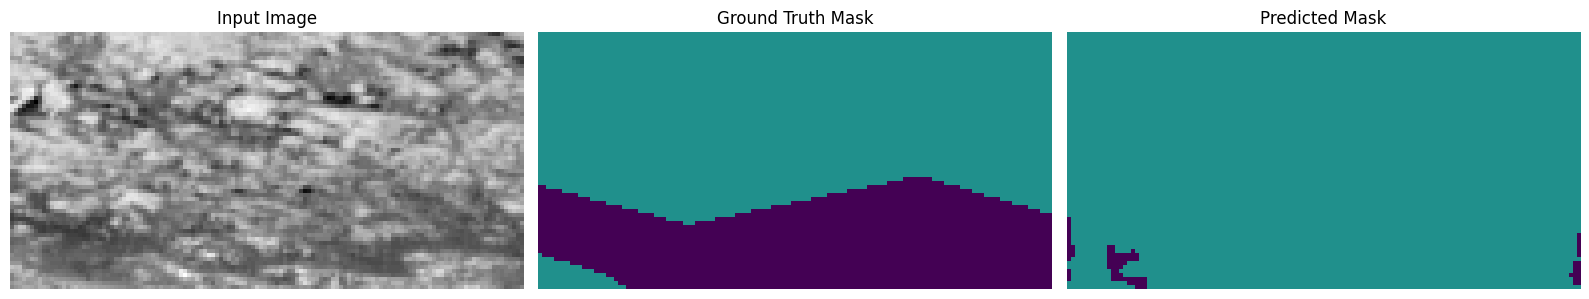

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - accuracy: 0.7247 - loss: 0.7528 - mean_iou: 0.4376 - val_accuracy: 0.7791 - val_loss: 0.6714 - val_mean_iou: 0.4772
Epoch 32/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.7264 - loss: 0.7487 - mean_iou: 0.4302 - val_accuracy: 0.7767 - val_loss: 0.6630 - val_mean_iou: 0.4717
Epoch 33/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 523ms/step - accuracy: 0.7271 - loss: 0.7537 - mean_iou: 0.4364 - val_accuracy: 0.7752 - val_loss: 0.6747 - val_mean_iou: 0.4723
Epoch 34/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.7234 - loss: 0.7545 - mean_iou: 0.4272 - val_accuracy: 0.7662 - val_loss: 0.6820 - val_mean_iou: 0.4616
Epoch 35/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 528ms/step - accuracy: 0.7197 - loss: 0.7577 - mean_iou: 0.4243 - val_accuracy: 0.7831 - val_loss: 0.6523 - val_mean_iou: 0.4793
Epoch 36/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7234 - loss: 0.7532 - mean_iou: 0.4283

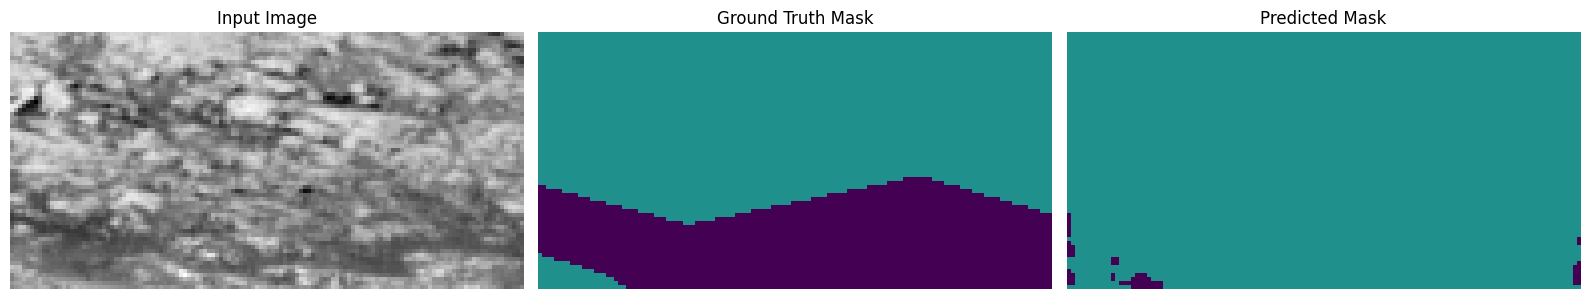

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.7237 - loss: 0.7526 - mean_iou: 0.4286 - val_accuracy: 0.7835 - val_loss: 0.6557 - val_mean_iou: 0.4794
Epoch 37/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.7327 - loss: 0.7436 - mean_iou: 0.4373 - val_accuracy: 0.7819 - val_loss: 0.6667 - val_mean_iou: 0.4819
Epoch 38/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.7199 - loss: 0.7643 - mean_iou: 0.4242 - val_accuracy: 0.7777 - val_loss: 0.6611 - val_mean_iou: 0.4681
Epoch 39/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 0.7382 - loss: 0.7324 - mean_iou: 0.4382 - val_accuracy: 0.7876 - val_loss: 0.6467 - val_mean_iou: 0.4835
Epoch 40/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 528ms/step - accuracy: 0.7385 - loss: 0.7298 - mean_iou: 0.4384 - val_accuracy: 0.7847 - val_loss: 0.6623 - val_mean_iou: 0.4797
Epoch 41/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7311 - loss: 0.7420 - mean_iou: 0.4364

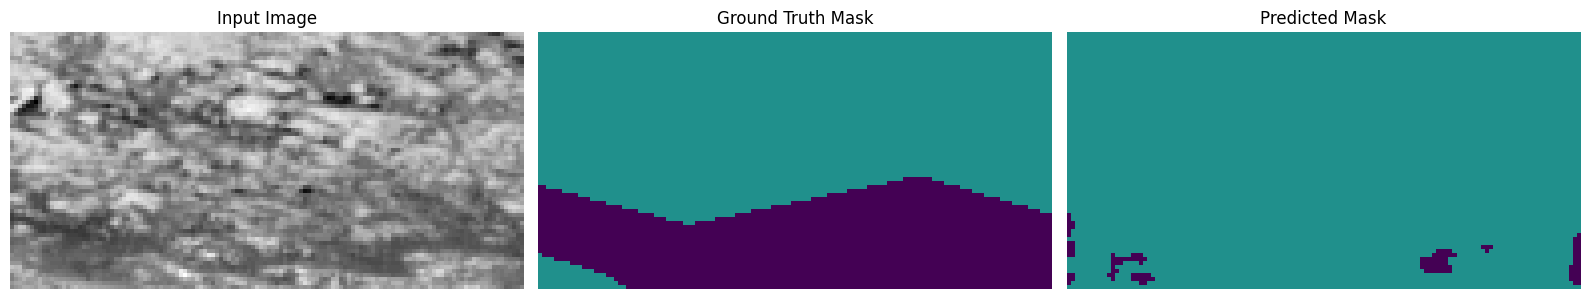

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - accuracy: 0.7315 - loss: 0.7413 - mean_iou: 0.4366 - val_accuracy: 0.7836 - val_loss: 0.6580 - val_mean_iou: 0.4810
Epoch 42/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7330 - loss: 0.7389 - mean_iou: 0.4396 - val_accuracy: 0.7820 - val_loss: 0.6532 - val_mean_iou: 0.4784
Epoch 43/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.7275 - loss: 0.7456 - mean_iou: 0.4263 - val_accuracy: 0.7784 - val_loss: 0.6624 - val_mean_iou: 0.4697
Epoch 44/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.7327 - loss: 0.7482 - mean_iou: 0.4337 - val_accuracy: 0.7798 - val_loss: 0.6609 - val_mean_iou: 0.4681
Epoch 45/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.7286 - loss: 0.7402 - mean_iou: 0.4336 - val_accuracy: 0.7813 - val_loss: 0.6619 - val_mean_iou: 0.4690
Epoch 46/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7465 - loss: 0.7136 - mean_iou: 0.4441

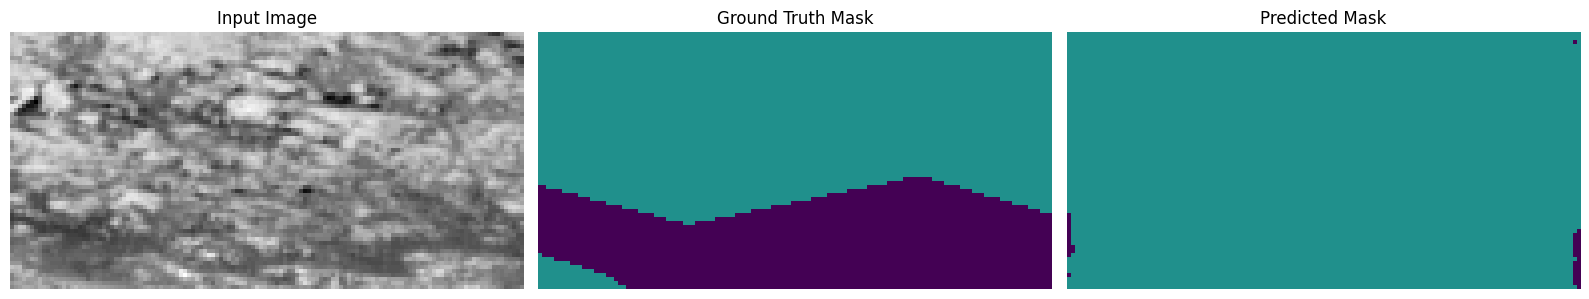

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.7465 - loss: 0.7136 - mean_iou: 0.4441 - val_accuracy: 0.7791 - val_loss: 0.6604 - val_mean_iou: 0.4706
Epoch 47/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7410 - loss: 0.7288 - mean_iou: 0.4400 - val_accuracy: 0.7877 - val_loss: 0.6417 - val_mean_iou: 0.4832
Epoch 48/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 0.7385 - loss: 0.7328 - mean_iou: 0.4370 - val_accuracy: 0.7870 - val_loss: 0.6483 - val_mean_iou: 0.4851
Epoch 49/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.7334 - loss: 0.7360 - mean_iou: 0.4349 - val_accuracy: 0.7900 - val_loss: 0.6431 - val_mean_iou: 0.4841
Epoch 50/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 0.7388 - loss: 0.7336 - mean_iou: 0.4404 - val_accuracy: 0.7746 - val_loss: 0.6676 - val_mean_iou: 0.4604
Epoch 51/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7489 - loss: 0.7148 - mean_iou: 0.4491

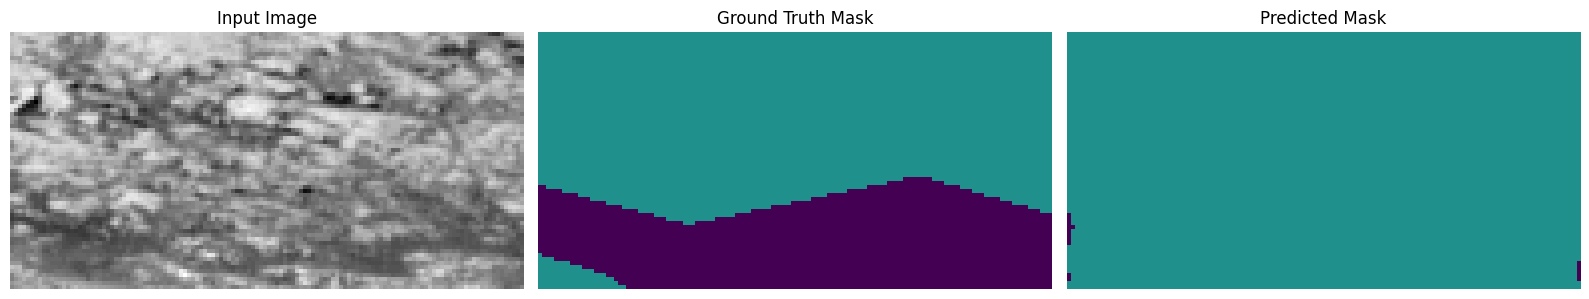

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - accuracy: 0.7490 - loss: 0.7146 - mean_iou: 0.4491 - val_accuracy: 0.7835 - val_loss: 0.6474 - val_mean_iou: 0.4714
Epoch 52/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 523ms/step - accuracy: 0.7413 - loss: 0.7171 - mean_iou: 0.4424 - val_accuracy: 0.7898 - val_loss: 0.6372 - val_mean_iou: 0.4783
Epoch 53/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 526ms/step - accuracy: 0.7323 - loss: 0.7350 - mean_iou: 0.4330 - val_accuracy: 0.7878 - val_loss: 0.6364 - val_mean_iou: 0.4754
Epoch 54/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 528ms/step - accuracy: 0.7509 - loss: 0.7055 - mean_iou: 0.4498 - val_accuracy: 0.7822 - val_loss: 0.6480 - val_mean_iou: 0.4624
Epoch 55/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 528ms/step - accuracy: 0.7484 - loss: 0.7057 - mean_iou: 0.4486 - val_accuracy: 0.7859 - val_loss: 0.6499 - val_mean_iou: 0.4707
Epoch 56/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7481 - loss: 0.7127 - mean_iou: 0.4463

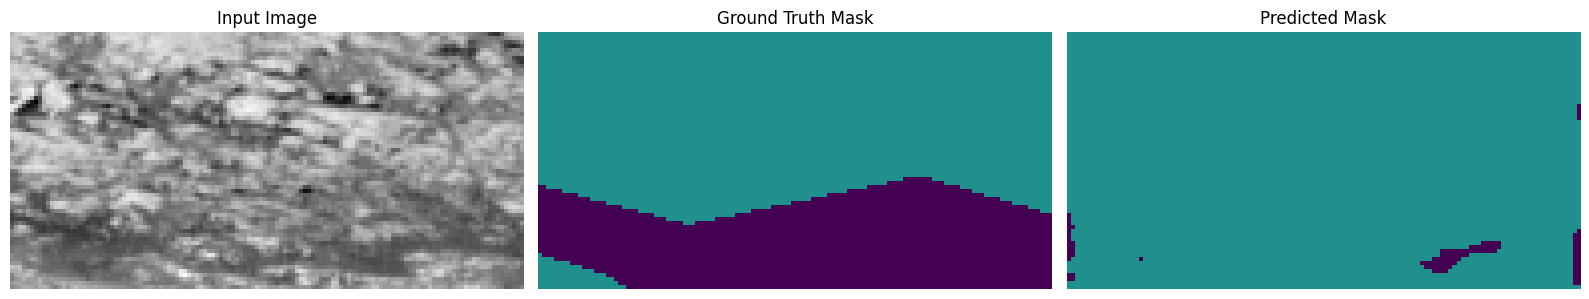

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - accuracy: 0.7481 - loss: 0.7126 - mean_iou: 0.4462 - val_accuracy: 0.7898 - val_loss: 0.6409 - val_mean_iou: 0.4766
Epoch 57/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - accuracy: 0.7446 - loss: 0.7200 - mean_iou: 0.4447 - val_accuracy: 0.7862 - val_loss: 0.6415 - val_mean_iou: 0.4749
Epoch 58/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.7450 - loss: 0.7091 - mean_iou: 0.4457 - val_accuracy: 0.7873 - val_loss: 0.6408 - val_mean_iou: 0.4739
Epoch 59/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 531ms/step - accuracy: 0.7470 - loss: 0.7110 - mean_iou: 0.4460 - val_accuracy: 0.7903 - val_loss: 0.6316 - val_mean_iou: 0.4779
Epoch 60/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.7421 - loss: 0.7162 - mean_iou: 0.4395 - val_accuracy: 0.7938 - val_loss: 0.6330 - val_mean_iou: 0.4809
Epoch 61/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7503 - loss: 0.7041 - mean_iou: 0.4520

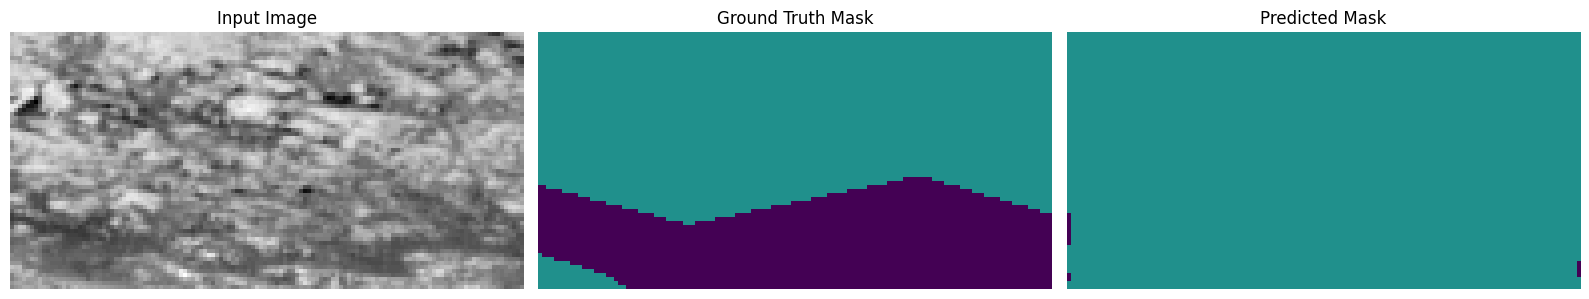

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step - accuracy: 0.7504 - loss: 0.7039 - mean_iou: 0.4519 - val_accuracy: 0.7904 - val_loss: 0.6331 - val_mean_iou: 0.4784
Epoch 62/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.7480 - loss: 0.7070 - mean_iou: 0.4442 - val_accuracy: 0.7933 - val_loss: 0.6310 - val_mean_iou: 0.4774
Epoch 63/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.7416 - loss: 0.7173 - mean_iou: 0.4412 - val_accuracy: 0.7890 - val_loss: 0.6280 - val_mean_iou: 0.4752
Epoch 64/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7514 - loss: 0.7094 - mean_iou: 0.4546 - val_accuracy: 0.7897 - val_loss: 0.6327 - val_mean_iou: 0.4797
Epoch 65/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7460 - loss: 0.7128 - mean_iou: 0.4398 - val_accuracy: 0.7914 - val_loss: 0.6278 - val_mean_iou: 0.4772
Epoch 66/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7478 - loss: 0.7059 - mean_iou: 0.4433

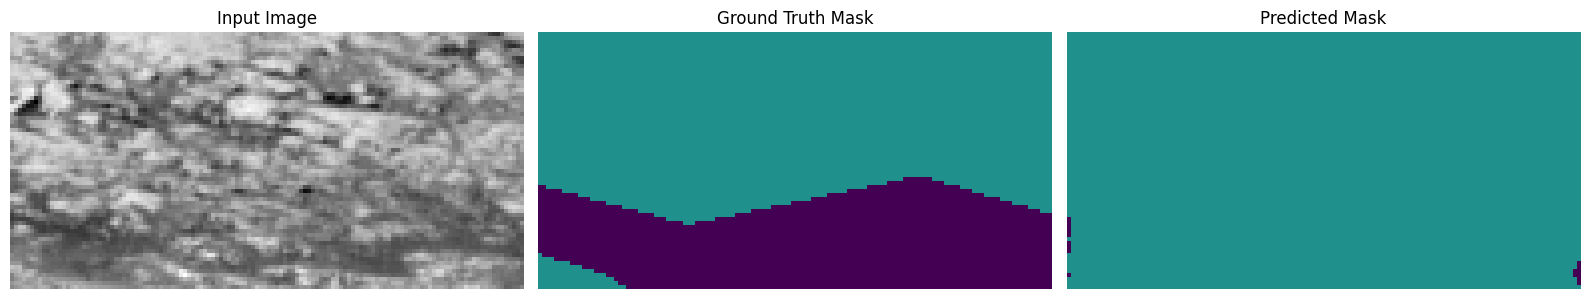

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7481 - loss: 0.7054 - mean_iou: 0.4435 - val_accuracy: 0.7951 - val_loss: 0.6209 - val_mean_iou: 0.4820
Epoch 67/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.7529 - loss: 0.6991 - mean_iou: 0.4492 - val_accuracy: 0.7875 - val_loss: 0.6296 - val_mean_iou: 0.4751
Epoch 68/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 0.7525 - loss: 0.7101 - mean_iou: 0.4518 - val_accuracy: 0.7931 - val_loss: 0.6227 - val_mean_iou: 0.4805
Epoch 69/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7517 - loss: 0.7048 - mean_iou: 0.4499 - val_accuracy: 0.7900 - val_loss: 0.6270 - val_mean_iou: 0.4745
Epoch 70/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.7464 - loss: 0.7121 - mean_iou: 0.4467 - val_accuracy: 0.7965 - val_loss: 0.6261 - val_mean_iou: 0.4817
Epoch 71/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7560 - loss: 0.6970 - mean_iou: 0.4627

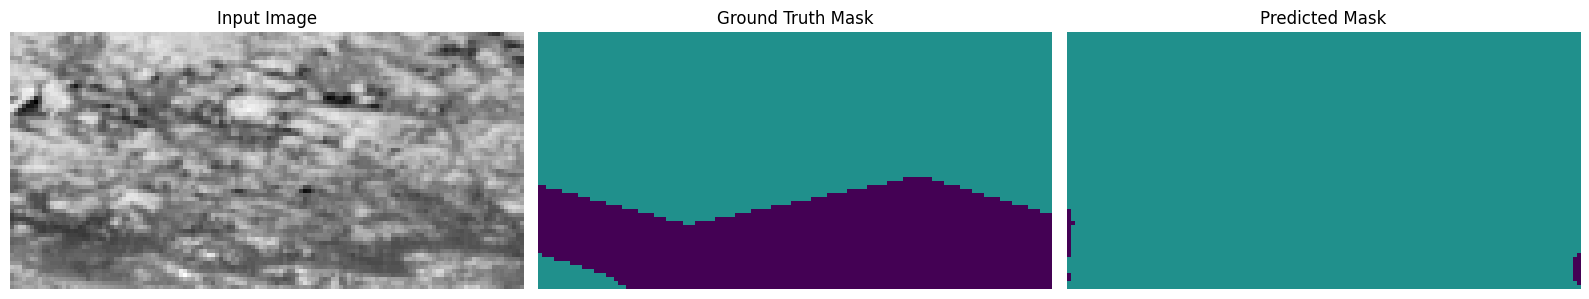

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.7562 - loss: 0.6966 - mean_iou: 0.4626 - val_accuracy: 0.7907 - val_loss: 0.6355 - val_mean_iou: 0.4771
Epoch 72/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.7568 - loss: 0.6967 - mean_iou: 0.4549 - val_accuracy: 0.7848 - val_loss: 0.6466 - val_mean_iou: 0.4674
Epoch 73/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7548 - loss: 0.6941 - mean_iou: 0.4541 - val_accuracy: 0.7901 - val_loss: 0.6399 - val_mean_iou: 0.4717
Final validation Mean Intersection Over Union: 48.51%


In [18]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [19]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_MultiResNet_{timestep_str}_{str(final_val_meanIoU)}.keras"
model.save(model_filename)


TypeError: SparseCategoricalCrossentropy.get_config() missing 1 required positional argument: 'self'

In [ ]:
#del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [20]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

ValueError: File not found: filepath=model_MultiResNet_241212_232800_48.51.keras. Please ensure the file is an accessible `.keras` zip file.

In [21]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step
Predictions shape: (10022, 64, 128)


In [22]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [23]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

In [ ]:
# import time
# import numpy as np
# import sounddevice as sd
#
# def generate_noise(duration=1, sample_rate=44100):
#     """Génère un bruit blanc de la durée spécifiée."""
#     samples = np.random.uniform(-1, 1, size=(duration * sample_rate,))
#     return samples
#
# # Paramètres
# sample_rate = 44100  # Fréquence d'échantillonnage en Hz
#
# try:
#     print("Le bruit infini est en cours... Interrompez l'exécution pour arrêter.")
#     while True:
#         noise = generate_noise(duration=1, sample_rate=sample_rate)
#         sd.play(noise, samplerate=sample_rate)
#         time.sleep(1)  # Attendre la fin de chaque segment avant de continuer
# except KeyboardInterrupt:
#     print("Exécution interrompue.")
#     sd.stop()


In [ ]:
# import os
# import requests
# import pygame
# import time
#
# # URL du fichier audio à télécharger
# audio_url = "https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3"
#
# # Nom du fichier local après téléchargement
# local_audio_path = "downloaded_sound.mp3"
#
# # Télécharger le fichier audio
# print("Téléchargement du fichier audio...")
# response = requests.get(audio_url, stream=True)
# if response.status_code == 200:
#     with open(local_audio_path, "wb") as audio_file:
#         for chunk in response.iter_content(chunk_size=1024):
#             audio_file.write(chunk)
#     print(f"Fichier audio téléchargé avec succès : {local_audio_path}")
# else:
#     print("Erreur lors du téléchargement du fichier audio.")
#     exit()
#
# # Initialisation de pygame
# pygame.mixer.init()
#
# # Charger et jouer le fichier audio
# pygame.mixer.music.load(local_audio_path)
# pygame.mixer.music.play(-1)  # -1 pour une boucle infinie
# print("Lecture du son en cours... Interrompez pour arrêter.")
#
# # Maintenir la lecture jusqu'à interruption
# try:
#     while True:
#         time.sleep(1)
# except KeyboardInterrupt:
#     print("Exécution interrompue.")
#     pygame.mixer.music.stop()
#
# # Nettoyer le fichier téléchargé (facultatif)
# if os.path.exists(local_audio_path):
#     os.remove(local_audio_path)
#     print(f"Fichier temporaire supprimé : {local_audio_path}")
#